In [1]:
import sys
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch

%matplotlib inline
print(f"Python version: {sys.version}\nNumpy version: {np.__version__}\nMatplotlib version: {matplotlib.__version__}\nPyTorch version: {torch.__version__}")

Python version: 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:49:36) [Clang 16.0.6 ]
Numpy version: 1.26.4
Matplotlib version: 3.8.0
PyTorch version: 2.2.1


# Problem 1

In [2]:
MNIST_DATA_PATH = "/Users/lucah/Library/CloudStorage/OneDrive-DurhamUniversity/Course Material & Work/SNU Year Abroad {SNU}/2-Spring Semester/Mathematical Foundations of Deep Neural Networks {MFDNN}/Lectures Slides {MFDNN}/Notebooks {MFDNN}/mnist_data"

## Setup

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.optim as optim
from torchvision.transforms import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt

lr = 0.001
batch_size = 100
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

## Step 1: Datasets

In [4]:
# MNIST dataset
dataset = datasets.MNIST(root=MNIST_DATA_PATH,
                         train=True,
                         transform=transforms.ToTensor(),
                         download=True)

train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [50000, 10000])

test_dataset = datasets.MNIST(root=MNIST_DATA_PATH,
                              train=False,
                              transform=transforms.ToTensor())

# KMNIST dataset, only need test dataset
anomaly_dataset = datasets.KMNIST(root='./kmnist_data/',
                                  train=False,
                                  transform=transforms.ToTensor(),
                                  download=True)

print(len(train_dataset))       # 50000
print(len(validation_dataset))  # 10000
print(len(test_dataset))        # 10000
print(len(anomaly_dataset))     # 10000

50000
10000
10000
10000


## Step 2: AutoEncoder

In [5]:
# Define Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        z = F.relu(self.fc3(x))
        return z

# Define Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(32, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 784)
    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        x = F.sigmoid(self.fc3(z))  # to make output's pixels are 0~1
        x = x.view(x.size(0), 1, 28, 28)
        return x

## Step 3: Instantiate model & define loss and optimizer

In [6]:
enc = Encoder().to(device)
dec = Decoder().to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=lr)

## Step 4: Training

00th epoch starting.                                             
01th epoch starting.                                             
02th epoch starting.                                             
03th epoch starting.                                             
04th epoch starting.                                             
05th epoch starting.                                             
06th epoch starting.                                             
07th epoch starting.                                             
08th epoch starting.                                             
09th epoch starting.                                             
Time elapsed in training is: 35.188708782196045n loss: 0.010327


Decoder(
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=784, bias=True)
)

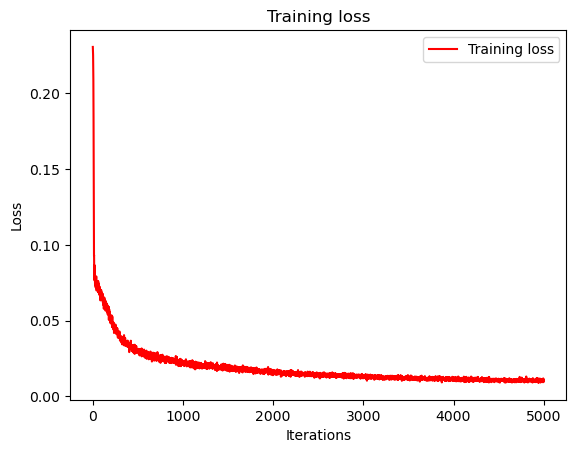

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

train_loss_list = []

import time
start = time.time()
for epoch in range(epochs) :
    print("{:02}th epoch starting.                                             ".format(epoch))
    enc.train()
    dec.train()
    for batch, (images, _) in enumerate(train_loader) :
        images = images.to(device)
        z = enc(images)
        reconstructed_images = dec(z)

        optimizer.zero_grad()
        train_loss = loss_function(images, reconstructed_images)
        train_loss.backward()
        train_loss_list.append(train_loss.item())

        optimizer.step()

        print(f"[Epoch {epoch:3d}] Processing batch #{batch:3d} reconstruction loss: {train_loss.item():.6f}", end='\r')
end = time.time()
print("Time elapsed in training is: {}".format(end - start))

# plotting train loss
plt.plot(range(1,len(train_loss_list)+1), train_loss_list, 'r', label='Training loss')
plt.title('Training loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

# switch to evaluation mode
enc.eval()
dec.eval()

## Step 5: Calculate standard deviation by using validation set (task)

In [13]:
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size)

def score_function(true, reconstructed):
    """
    Calculate the score value for each image (summed across all pixels in ea image) 
    in a batch of true and reconstructed images.
    """
    diff = true - reconstructed
    # solutions use .mean() rather than sum() to get pixel-wise average error rather than total error accumulated over entire image
    return torch.square(diff).sum(dim=[2,3]).squeeze()  # sum the square differences per pixel (i.e. norm over whole image)

scores = torch.tensor([]).to(device)
for images, _ in validation_loader:
    images = images.to(device)  # Y_i s
    z = enc(images)
    reconstructed_images = dec(z)  # D(E(Y_i)) s

    scores = torch.concatenate((scores, score_function(images, reconstructed_images)))

mean = scores.mean().item()
std = scores.std().item()
threshold = mean + 3 * std
print("threshold: ", threshold)

threshold:  22.907926559448242


## Step 6: Anomaly detection (mnist) (task)

In [9]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)

anomaly_count = 0
for images, _ in test_loader:
    images = images.to(device)  # Y_i s
    z = enc(images)
    reconstructed_images = dec(z)  # D(E(Y_i)) s

    # increase anomaly count by number of images that have a score greater than the threshold
    anomaly_count += (score_function(images, reconstructed_images) > threshold).sum().item()

# Type I error = false positive = how many MNIST 'normal' images are incorrectly detected as anomalies
print(f'Type I error rate: {100*anomaly_count/len(test_dataset):.2f}%')

Type I error rate: 0.91%


## Step 7: Anomaly detection (kmnist) (task)

In [10]:
anomaly_loader = torch.utils.data.DataLoader(dataset=anomaly_dataset, batch_size=batch_size)

non_anomaly_count = 0
for images, _ in anomaly_loader:
    images = images.to(device)  # Y_i s
    z = enc(images)
    reconstructed_images = dec(z)  # D(E(Y_i)) s
    
    # increase non-anomaly count by number of images that have a score not greater than the threshold
    non_anomaly_count += (score_function(images, reconstructed_images) <= threshold).sum().item()
    # non_anomaly_count += (score_function(images, reconstructed_images) > threshold).logical_not().sum().item()
    
# Type II error = false negative = how many KMNIST 'anomaly' images are incorrectly detected as normal
print(f'Type II error rate: {100*non_anomaly_count/len(anomaly_dataset):.2f}%')

Type II error rate: 3.79%


# Problem 2

## (Given starter code)

In [4]:
import torch
import torch.utils.data as data 
import torch.nn as nn
from torch.distributions.normal import Normal
import numpy as np
import matplotlib.pyplot as plt

def mixture_of_gaussians(num, mu_var=(-1,0.25, 0.2,0.25, 1.5,0.25)):
    n = num // 3
    m1,s1,m2,s2,m3,s3 = mu_var
    gaussian1 = np.random.normal(loc=m1, scale=s1, size=(n,))
    gaussian2 = np.random.normal(loc=m2, scale=s2, size=(n,))
    gaussian3 = np.random.normal(loc=m3, scale=s3, size=(num-n,))
    return np.concatenate([gaussian1, gaussian2, gaussian3])

class MyDataset(data.Dataset):
    def __init__(self, array):
        super().__init__()
        self.array = array

    def __len__(self):
        return len(self.array)

    def __getitem__(self, index):
        return self.array[index]

## Flow model

Adpated from `Chapter 5 Code.ipynb`

In [5]:
class Flow1d(nn.Module):
    def __init__(self, n_components):
        super(Flow1d, self).__init__()
        self.weight_logits = nn.Parameter(torch.ones(n_components), requires_grad=True)
        self.mus = nn.Parameter(torch.randn(n_components), requires_grad=True)
        self.log_sigmas = nn.Parameter(torch.zeros(n_components), requires_grad=True)

    def forward(self, x):
        x = x.view(-1,1)
        weights = self.weight_logits.exp().view(1,-1)  # edited - no softmax, just exponentiate
        distribution = Normal(self.mus, self.log_sigmas.exp())
        z = ((distribution.cdf(x) - 0.5) * weights).sum(dim=1)  # edited - subtract 0.5
        # distribution.log_prob(x).exp() is the PDF (the derivative of CDF which we want for dz_by_dx)
        dz_by_dx = (distribution.log_prob(x).exp() * weights).sum(dim=1)
        return z, dz_by_dx

## Train/fit flow model

Directly copied from `Chapter 5 Code.ipynb` with hyperparameter tuning

In [6]:
epochs = 200
learning_rate = 5.6e-3
batch_size = 128
n_components = 5  # specified in problem
target_distribution = Normal(0.0, 1.0)  # specified in problem

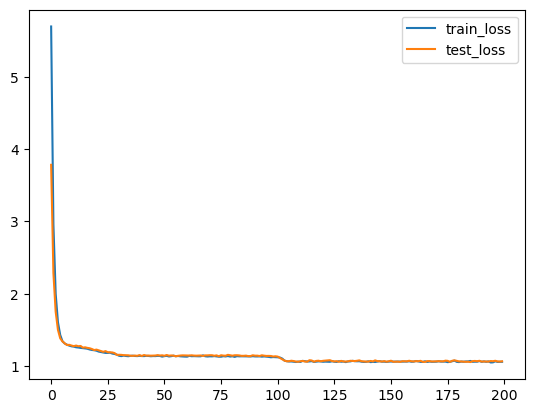

In [7]:
################################
# STEP 3: Define Loss Function #
################################
def loss_function(target_distribution, z, dz_by_dx):
    # log(p_Z(z)) = target_distribution.log_prob(z)
    # log(dz/dx) = dz_by_dx.log() (flow is defined so that dz/dx>0)
    log_likelihood = target_distribution.log_prob(z) + dz_by_dx.log()
    return -log_likelihood.mean()  #flip sign (minimise in code, maximise in original problem), and sum of data X_1,...X_N
    
###########################
# STEP 4: Train the model #
########################### 

# create dataloader
n_train, n_test = 5000, 1000
train_data = mixture_of_gaussians(n_train)
test_data = mixture_of_gaussians(n_test)

train_loader = data.DataLoader(MyDataset(train_data), batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(MyDataset(test_data), batch_size=batch_size, shuffle=True)

# create model
flow = Flow1d(n_components)
optimizer = torch.optim.Adam(flow.parameters(), lr=learning_rate)

train_losses, test_losses = [], []

for epoch in range(epochs):
    # train
#     flow.train()
    mean_loss = 0
    for i, x in enumerate(train_loader):
        z, dz_by_dx = flow(x)
        loss = loss_function(target_distribution, z, dz_by_dx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        mean_loss += loss.item()
    train_losses.append(mean_loss/(i+1))

    # test
    flow.eval()
    mean_loss = 0
    for i, x in enumerate(test_loader):
        z, dz_by_dx = flow(x)
        loss = loss_function(target_distribution, z, dz_by_dx)

        mean_loss += loss.item()
    test_losses.append(mean_loss/(i+1))
    
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.legend()

## Visualise results

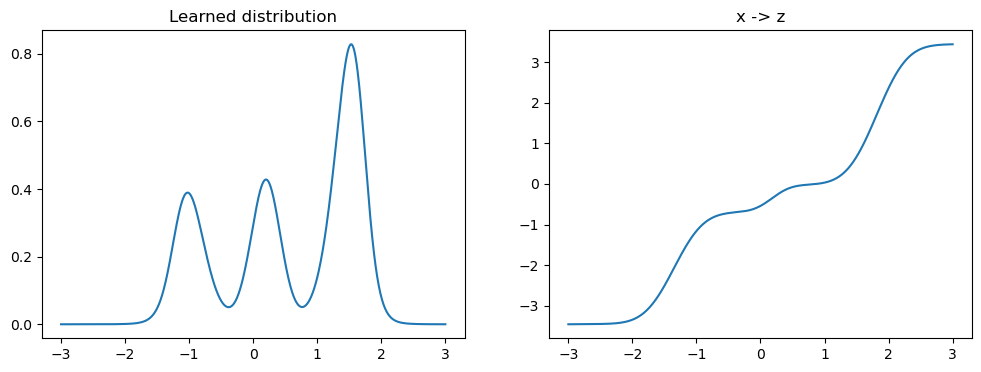

In [8]:
x = np.linspace(-3,3,1000)
with torch.no_grad():
    z, dz_by_dx = flow(torch.FloatTensor(x))
    px = (target_distribution.log_prob(z) + dz_by_dx.log()).exp().cpu().numpy()
    
_, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].plot(x,px)
_ = axes[0].set_title('Learned distribution')

_ = axes[1].plot(x,z)
_ = axes[1].set_title('x -> z')

### Investigate efficacy of learned transformation on train data, i.e. visualise $p_Z$ using train data

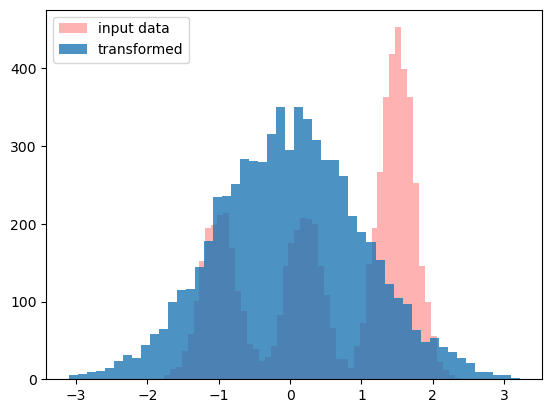

In [9]:
with torch.no_grad():
    z, _ = flow(torch.FloatTensor(train_loader.dataset.array))
    
_ = plt.hist(np.array(train_loader.dataset.array), bins=50, alpha=0.3, color='r', label='input data')
_ = plt.hist(np.array(z), bins=50, alpha=0.8, label='transformed')
_ = plt.legend()

# overlay additional 'true' normal distribution
# z_true = torch.tensor(np.linspace(-3,3,1000))
# plt.plot(z_true, target_distribution.log_prob(z_true).exp().numpy()*[scaling?], 'r')

The learned transformation is very effective on the training data with a very good normal-looking bell curve

### Investigate efficacy of learned transformation on test data, i.e. visualise $p_Z$ using test data

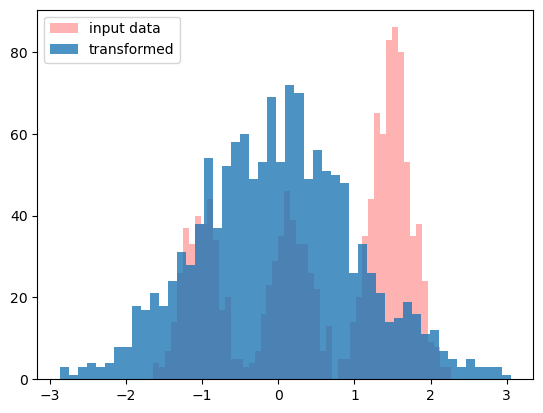

In [10]:
with torch.no_grad():
    z, _ = flow(torch.FloatTensor(test_loader.dataset.array))
    
_ = plt.hist(np.array(test_loader.dataset.array), bins=50, alpha=0.3, color='r', label='input data')
_ = plt.hist(np.array(z), bins=50, alpha=0.8, label='transformed')
_ = plt.legend()

The transformation is (as expected) less effective on the test data but still manages to funamentally transform the input data much closer towards a normal distribution.

### See 'true' distribution using $f_\theta^{-1}$ 

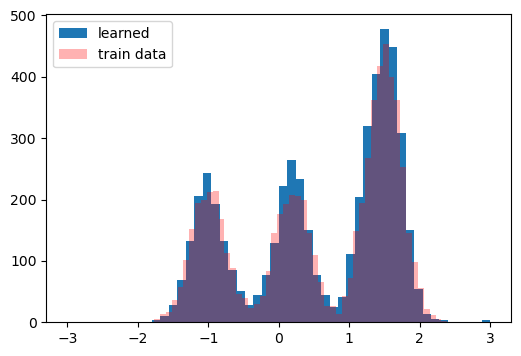

In [12]:
# sampling from z~N(0,1)
N = 5000
z = torch.normal(mean = torch.zeros(N), std = torch.ones(N))
x_low = torch.full((N,), -3.)
x_high = torch.full((N,), 3.)

# Perform bisection to invert the flow
with torch.no_grad():
    for _ in range(30):
        m = (x_low+x_high)/2
        f,_ = flow(m)
        x_high[f>=z] = m[f>=z]
        x_low[f<z] = m[f<z]
    x = (x_low+x_high)/2

fig = plt.figure(figsize=(6,4))
_ = plt.hist(np.array(x), bins=50, label='learned z->x')
_ = plt.hist(np.array(train_data), bins=50, alpha=0.3, color='r', label='train data')
plt.legend()
plt.show()